In [63]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utils
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from lmfit import Parameters, minimize, report_fit
import matplotlib.ticker as ticker

import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\kearb\\Documents\\GitHub\\Python Projects\\AdvLabs\\Lab 1\\utils.py'>

In [2]:
#Load ALL THE DATA
spectrum_dict = utils.load_data(filepath=r'Data/Transmittance/Water-vapor.ASC', key='Water Vapor')
spectrum_dict.update(utils.load_data(r'Data/Transmittance/polystyrene.ASC', key='Polystyrene'))
spectrum_dict.update(utils.load_data(r'Data/Transmittance/glass.ASC', key ='Glass'))
spectrum_dict.update(utils.load_data(r'Data/Transmittance/NaCl blocking filter.ASC', key='NaCl'))
spectrum_dict.update(utils.load_data(r'Data/Transmittance/water vapor with plate.ASC', key='Water Vapor with Plate'))
spectrum_dict.update(utils.load_data(r'Data/Transmittance/AlO2 transmittance.ASC', key='Sapphire Transmittance'))
spectrum_dict.update(utils.load_data(r'Data/Transmittance/Si transmission try 2.ASC', key='Silicon Transmittance'))
spectrum_dict.update(utils.load_data(r'Data/Transmittance/ZnO front try 1.ASC', key='Zinc Oxide Front'))
spectrum_dict.update(utils.load_data(r'Data/Reflectivity/Gold Mirror baseline reflectivity.ASC', key='Gold Mirror Reflectivity'))
spectrum_dict.update(utils.load_data(r'Data/Reflectivity/AlO2 Reflectivity full range.ASC', key='Sapphire Reflectivity'))
spectrum_dict.update(utils.load_data(r'Data/Reflectivity/Silicone reflectivity spectrum.ASC', key='Silicone Reflectivity'))
spectrum_dict.update(utils.load_data(r'Data/Reflectivity/ZnO thin film reflectivity.ASC', key='Zinc Oxide Reflectivity'))
spectrum_dict.update(utils.load_data(r'Data/Reflectivity/GaAs reflectivity spectrum.ASC', key='Gallium Arsenide Reflectivity'))
print(spectrum_dict.keys())




dict_keys(['Water Vapor', 'Polystyrene', 'Glass', 'NaCl', 'Water Vapor with Plate', 'Sapphire Transmittance', 'Silicon Transmittance', 'Zinc Oxide Front', 'Gold Mirror Reflectivity', 'Sapphire Reflectivity', 'Silicone Reflectivity', 'Zinc Oxide Reflectivity', 'Gallium Arsenide Reflectivity'])


In [3]:
spectrum_dict = utils.normalize(spectrum_dict)

Data for Water Vapor successfully normalized

Data for Polystyrene successfully normalized

Data for Glass successfully normalized

Data for NaCl successfully normalized

Data for Water Vapor with Plate successfully normalized

Data for Sapphire Transmittance successfully normalized

Data for Silicon Transmittance successfully normalized

Data for Zinc Oxide Front successfully normalized

Data for Gold Mirror Reflectivity successfully normalized

Data for Sapphire Reflectivity successfully normalized

Data for Silicone Reflectivity successfully normalized

Data for Zinc Oxide Reflectivity successfully normalized

Data for Gallium Arsenide Reflectivity successfully normalized



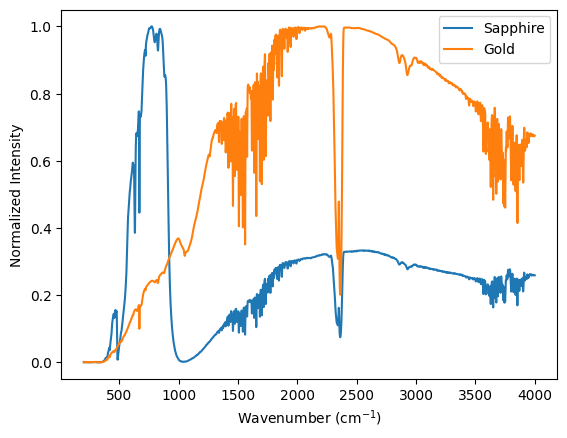

In [5]:
sapphire_x = spectrum_dict['Sapphire Reflectivity']['Wavenumber']
sapphire_y = spectrum_dict['Sapphire Reflectivity']['Normalized Intensity']
gold_x = spectrum_dict['Gold Mirror Reflectivity']['Wavenumber']
gold_y = spectrum_dict['Gold Mirror Reflectivity']['Normalized Intensity']

plt.plot(sapphire_x, sapphire_y, label='Sapphire')
plt.plot(gold_x, gold_y, label='Gold')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Normalized Intensity')
plt.legend()
plt.show()



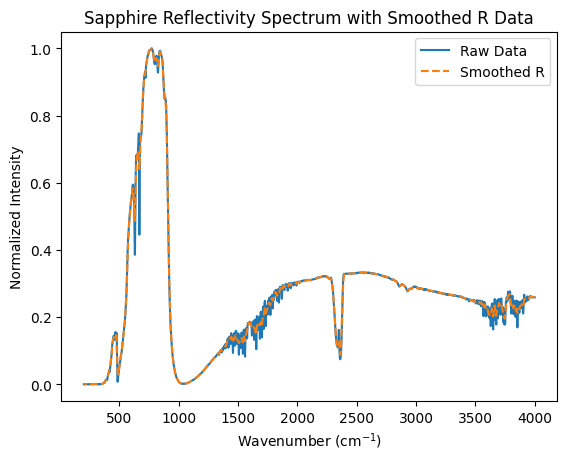

In [6]:
from scipy.ndimage import gaussian_filter1d
# Apply Gaussian smoothing
sigma = 2  # Standard deviation of the Gaussian kernel
smoothed_Y = gaussian_filter1d(spectrum_dict['Sapphire Reflectivity']['Normalized Intensity'], sigma=sigma)
for i in range(0, 5):
    smoothed_Y = gaussian_filter1d(smoothed_Y, sigma=sigma)


#Plot the sapphire reflectivity spectrum and the smoothed R data on the same plot
plt.plot(spectrum_dict['Sapphire Reflectivity']['Wavenumber'], spectrum_dict['Sapphire Reflectivity']['Normalized Intensity'], label='Raw Data')
plt.plot(spectrum_dict['Sapphire Reflectivity']['Wavenumber'], smoothed_Y, label='Smoothed R', linestyle='--')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Normalized Intensity')
plt.title('Sapphire Reflectivity Spectrum with Smoothed R Data')
plt.legend()
plt.show()


Fitted parameters:
eps_inf = 1.629
S1 = 1.470
w01 = 639.192
g1 = 10.761
S2 = 0.000
w02 = 908.599
g2 = 6.355
S3 = 0.151
w03 = 680.000
g3 = 12.305


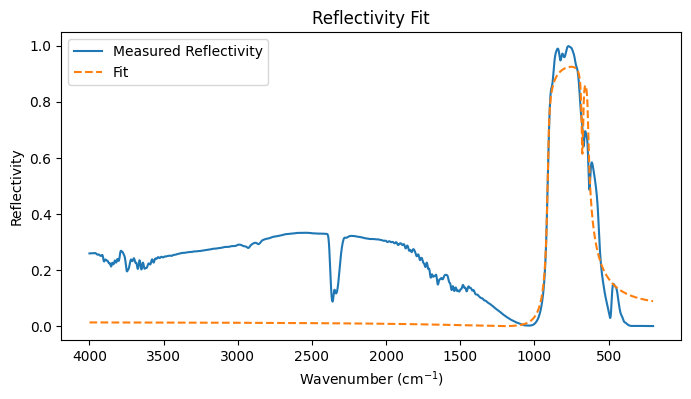

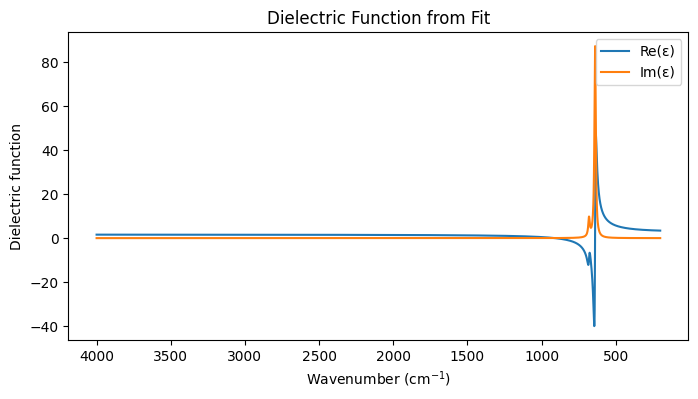

In [ ]:
# Oscillator 1 fitted values (from your last fit)
S1_fit = 1.77
w01_fit = 647.0
g1_fit = 11.5

# Bounds with small wiggle room
S1_bounds = (S1_fit - 0.3, S1_fit + 0.3)
w01_bounds = (w01_fit - 10, w01_fit + 10)
g1_bounds = (g1_fit - 3, g1_fit + 3)

# Define dielectric function separately (Lorentz oscillators)
def dielectric_function(w, eps_inf,
                        S1, w01, g1,
                        S2, w02, g2,
                        S3, w03, g3
        # S4, w04, g4
):
    i = 1j
    eps = eps_inf + \
          S1 * w01**2 / (w01**2 - w**2 - i * g1 * w) + \
          S2 * w02**2 / (w02**2 - w**2 - i * g2 * w) + \
          S3 * w03**2 / (w03**2 - w**2 - i * g3 * w)
    return eps

# Reflectivity model to fit (returns R)
def reflectivity_model(w, eps_inf,
                        S1, w01, g1,
                        S2, w02, g2,
                        S3, w03, g3
):
    eps = dielectric_function(w, eps_inf,
                            S1, w01, g1,
                            S2, w02, g2,
                            S3, w03, g3
    )
    sqrt_eps = np.sqrt(eps)
    R = np.abs((1 - sqrt_eps) / (1 + sqrt_eps))**2
    return R.real  # real, since reflectivity is real-valued

# Initial parameter guesses
p0 = [
    1.809,        # eps_inf
    S1_fit, w01_fit, g1_fit,  # S1, w01, g1
    4.0, 900.0, 20.0,  # S2, w02, g2
    0.5, 700.0, 10.0   # S3, w03, g3
]

param_names = [
    'eps_inf',
    'S1', 'w01', 'g1',
    'S2', 'w02', 'g2',
    'S3', 'w03', 'g3'
]
lower_bounds = [
    0.5,     # eps_inf
    S1_bounds[0], w01_bounds[0], g1_bounds[0],  # S1, w01, g1
    0.0, 850.0, 1.0,  # S2, w02, g2
    0.0, 680.0, 1.0   # S3, w03, g3
]
upper_bounds = [
    10.0,
    S1_bounds[1], w01_bounds[1], g1_bounds[1],
    20.0, 950.0, 50.0,
    20.0, 720.0, 20.0
]

wavenumber = np.array(spectrum_dict['Sapphire Reflectivity']['Wavenumber'])
R_normalized = np.array(smoothed_Y)

# Optional: restrict fitting range to where phonon modes appear, e.g. 400-1300 cm^-1
fit_mask = (wavenumber > 300) & (wavenumber < 1000)
w_fit = wavenumber[fit_mask]
R_fit = R_normalized[fit_mask]

popt, pcov = curve_fit(
    reflectivity_model,
    w_fit,
    R_fit,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
    maxfev=5000
)

print("Fitted parameters:")
for name, val in zip(param_names, popt):
    print(f"{name} = {val:.3f}")

# Calculate dielectric function using fitted params
eps_fit = dielectric_function(wavenumber, *popt)

# Plot reflectivity fit
plt.figure(figsize=(8,4))
plt.plot(wavenumber, R_normalized, label='Measured Reflectivity')
plt.plot(wavenumber, reflectivity_model(wavenumber, *popt), '--', label='Fit')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Reflectivity')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Reflectivity Fit')
plt.show()

# Plot dielectric function
plt.figure(figsize=(8,4))
plt.plot(wavenumber, eps_fit.real, label='Re(ε)')
plt.plot(wavenumber, eps_fit.imag, label='Im(ε)')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Dielectric function')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Dielectric Function from Fit')
plt.show()


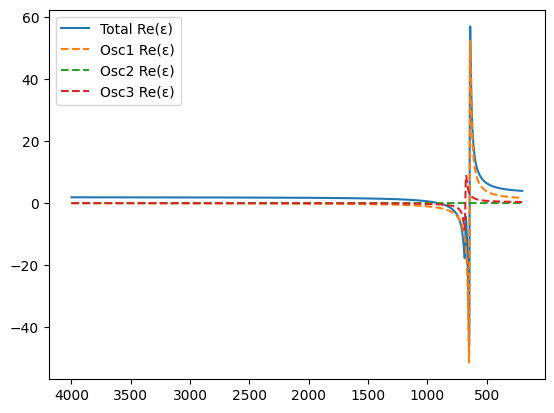

In [43]:
w = wavenumber
eps_inf = popt[0]
S1, w01, g1 = popt[1:4]
S2, w02, g2 = popt[4:7]
S3, w03, g3 = popt[7:10]

def single_oscillator_eps(w, eps_inf, S, w0, g):
    i = 1j
    return eps_inf + S * w0**2 / (w0**2 - w**2 - i * g * w)

plt.plot(w, dielectric_function(w, *popt).real, label='Total Re(ε)')
plt.plot(w, single_oscillator_eps(w, 0, S1, w01, g1).real, '--', label='Osc1 Re(ε)')
plt.plot(w, single_oscillator_eps(w, 0, S2, w02, g2).real, '--', label='Osc2 Re(ε)')
plt.plot(w, single_oscillator_eps(w, 0, S3, w03, g3).real, '--', label='Osc3 Re(ε)')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

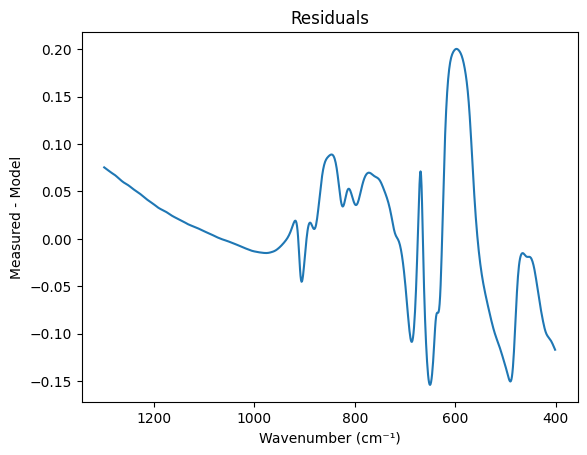

In [24]:
plt.plot(w_fit, R_fit - reflectivity_model(w_fit, *popt))
plt.title("Residuals")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Measured - Model")
plt.gca().invert_xaxis()
plt.show()

Fitted parameters:
eps_inf = 0.100 ± N/A
S1 = 0.000 ± N/A
w0_1 = 819.809 ± N/A
g1 = 91.344 ± N/A
S2 = 0.000 ± N/A
w0_2 = 797.173 ± N/A
g2 = 47.632 ± N/A
S3 = 0.017 ± N/A
w0_3 = 824.306 ± N/A
g3 = 9.054 ± N/A
S4 = 0.000 ± N/A
w0_4 = 750.002 ± N/A
g4 = 19.215 ± N/A
S5 = 4.740 ± N/A
w0_5 = 730.000 ± N/A
g5 = 2.267 ± N/A
S6 = 0.000 ± N/A
w0_6 = 677.661 ± N/A
g6 = 6.476 ± N/A


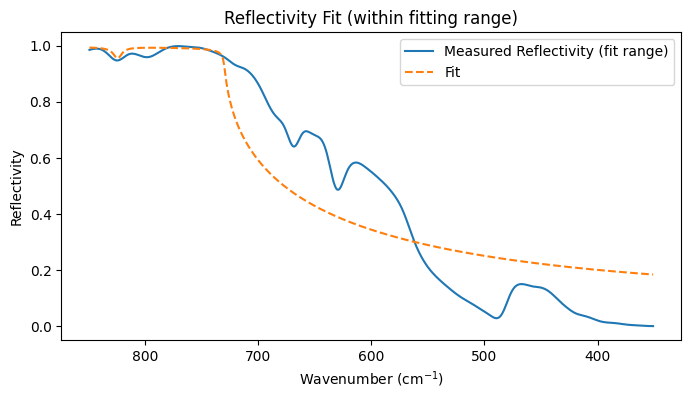

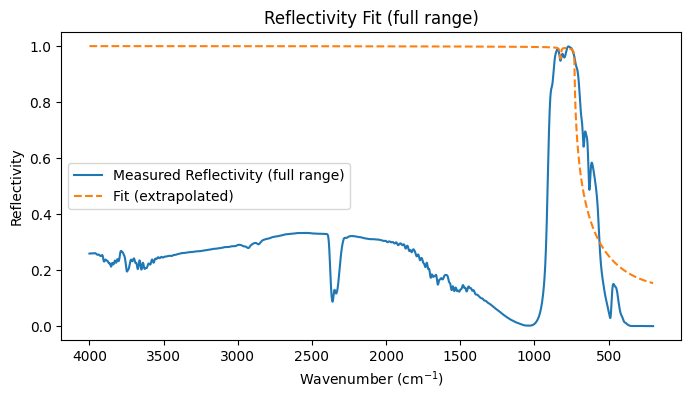

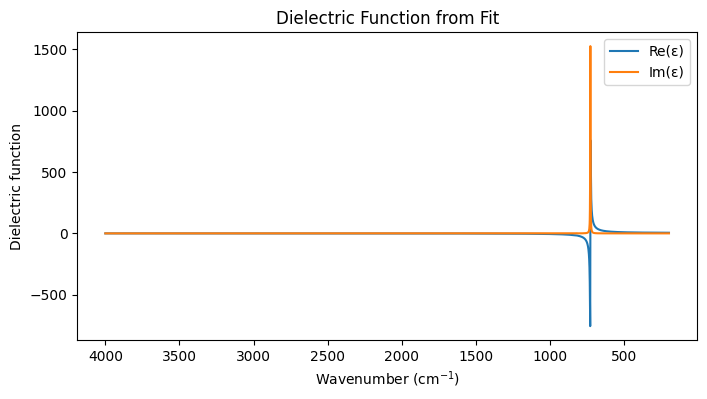

In [75]:
# --- Your data ---
wavenumber = np.array(spectrum_dict['Sapphire Reflectivity']['Wavenumber'])
R_normalized = np.array(smoothed_Y)

# Restrict fitting range (adjust as needed)
fit_mask = (wavenumber > 350) & (wavenumber < 850)
w_fit = wavenumber[fit_mask]
R_fit = R_normalized[fit_mask]

# --- Define dielectric function with n oscillators ---
def dielectric_function(w, params, n_osc=6):
    i = 1j
    eps_inf = params['eps_inf'].value
    eps = eps_inf + 0j
    for n in range(1, n_osc+1):
        S = params[f'S{n}'].value
        w0 = params[f'w0_{n}'].value
        g = params[f'g{n}'].value
        eps += S * w0**2 / (w0**2 - w**2 - i * g * w)
    return eps

# --- Reflectivity model from dielectric function ---
def reflectivity_model(w, params, n_osc=6):
    eps = dielectric_function(w, params, n_osc)
    sqrt_eps = np.sqrt(eps)
    R = np.abs((1 - sqrt_eps) / (1 + sqrt_eps))**2
    return R.real

# --- Residual function for fitting ---
def residual(params, w, data, n_osc=6):
    model = reflectivity_model(w, params, n_osc)
    return model - data

# --- Setup Parameters ---
params = Parameters()
params.add('eps_inf', value=2, min=0.1, max=10)

# Initial guesses for oscillators (tweak as needed)
initial_guesses = [
    # S,    w0,    g
    (1.8,  845,   15),
    (0.5,  825,   40),
    (0.2,  812,   50),
    (0.3,  800,   20),
    (0.1,  780,   10),
    (0.05, 660,   5),
]

for n, (S_init, w0_init, g_init) in enumerate(initial_guesses, start=1):
    params.add(f'S{n}', value=S_init, min=0, max=5)
    params.add(f'w0_{n}', value=w0_init, min=w0_init-50, max=w0_init+50)
    params.add(f'g{n}', value=g_init, min=1, max=100)

# --- Perform the fit ---
result = minimize(residual, params, args=(w_fit, R_fit), kws={'n_osc': 6}, max_nfev=10000)

# --- Print fitted parameters ---
print("Fitted parameters:")
for name, par in result.params.items():
    print(f"{name} = {par.value:.3f} ± {par.stderr if par.stderr else 'N/A'}")

# --- Plot Reflectivity Fit in fitting range ---
plt.figure(figsize=(8, 4))
plt.plot(w_fit, R_fit, label='Measured Reflectivity (fit range)')
plt.plot(w_fit, reflectivity_model(w_fit, result.params, n_osc=6), '--', label='Fit')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Reflectivity')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Reflectivity Fit (within fitting range)')
plt.show()

# --- Plot Reflectivity Fit on full range (extrapolated) ---
plt.figure(figsize=(8, 4))
plt.plot(wavenumber, R_normalized, label='Measured Reflectivity (full range)')
plt.plot(wavenumber, reflectivity_model(wavenumber, result.params, n_osc=6), '--', label='Fit (extrapolated)')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Reflectivity')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Reflectivity Fit (full range)')
plt.show()

# --- Plot Dielectric function (full range) ---
eps_fit = dielectric_function(wavenumber, result.params, n_osc=6)
plt.figure(figsize=(8, 4))
plt.plot(wavenumber, eps_fit.real, label='Re(ε)')
plt.plot(wavenumber, eps_fit.imag, label='Im(ε)')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Dielectric function')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Dielectric Function from Fit')
plt.show()

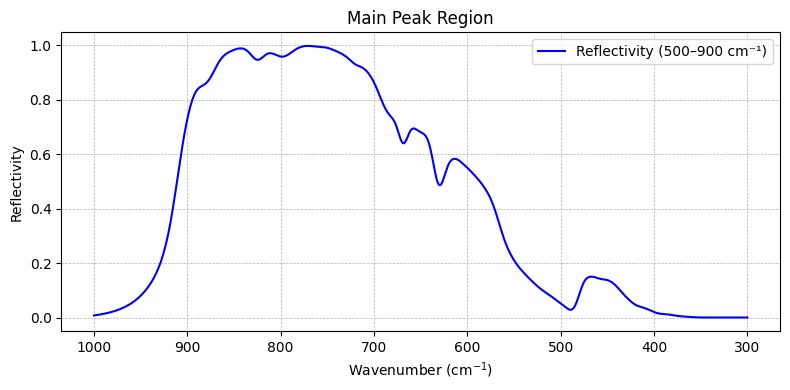

In [69]:
# Filter the main peak range
main_peak_mask = (wavenumber >= 300) & (wavenumber <= 1000)
w_main = wavenumber[main_peak_mask]
R_main = R_normalized[main_peak_mask]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(w_main, R_main, label='Reflectivity (500–900 cm⁻¹)', color='blue')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Reflectivity')
plt.title('Main Peak Region')
plt.gca().invert_xaxis()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

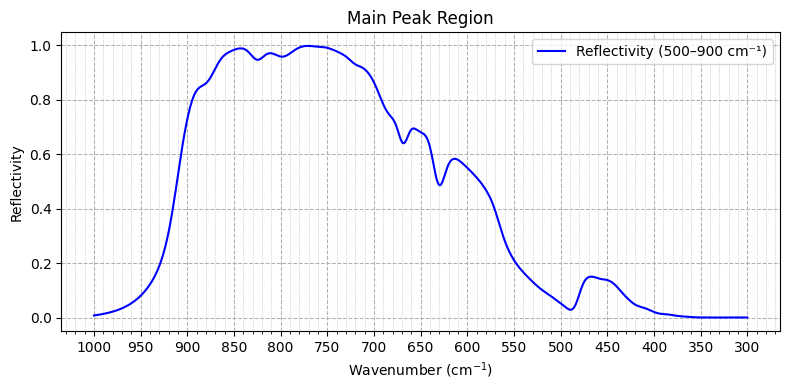

In [70]:
plt.figure(figsize=(8, 4))
plt.plot(w_main, R_main, label='Reflectivity (500–900 cm⁻¹)', color='blue')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Reflectivity')
plt.title('Main Peak Region')

# Invert x-axis
plt.gca().invert_xaxis()

# Set major ticks every 50, minor every 10
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))

# Add grid
ax.grid(True, which='major', linestyle='--', linewidth=0.75)
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

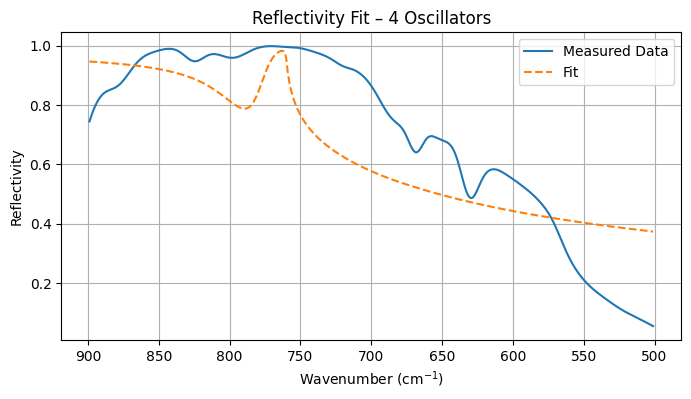

In [74]:
# Assume you already have `wavenumber` and `R_normalized` from your data
# Fit range: focus around main peak
fit_mask = (wavenumber > 500) & (wavenumber < 900)
w_fit = wavenumber[fit_mask]
R_fit = R_normalized[fit_mask]

# Define dielectric function with 4 oscillators
def dielectric_function(w, eps_inf, S1, w01, g1, S2, w02, g2, S3, w03, g3, S4, w04, g4):
    i = 1j
    eps = eps_inf \
        + S1 * w01**2 / (w01**2 - w**2 - i * g1 * w) \
        + S2 * w02**2 / (w02**2 - w**2 - i * g2 * w) \
        + S3 * w03**2 / (w03**2 - w**2 - i * g3 * w) \
        + S4 * w04**2 / (w04**2 - w**2 - i * g4 * w)
    return eps

# Reflectivity model
def reflectivity(w, eps_inf, S1, w01, g1, S2, w02, g2, S3, w03, g3, S4, w04, g4):
    eps = dielectric_function(w, eps_inf, S1, w01, g1, S2, w02, g2, S3, w03, g3, S4, w04, g4)
    sqrt_eps = np.sqrt(eps)
    return np.abs((1 - sqrt_eps) / (1 + sqrt_eps))**2

# Initial guesses: [eps_inf, S1, w01, g1, ..., S4, w04, g4]
initial_guesses = [
    2.0,      # eps_inf
    1.0, 845, 10,  # Oscillator 1
    0.5, 812, 10,  # Oscillator 2
    0.5, 780, 15,  # Oscillator 3
    0.2, 660, 20   # Oscillator 4
]

# Bounds: (min, max)
bounds_lower = [
    0.1,      # eps_inf
    0.01, 830, 1,  # S1, w01, g1
    0.01, 800, 1,  # S2, w02, g2
    0.01, 760, 1,  # S3, w03, g3
    0.01, 640, 1   # S4, w04, g4
]
bounds_upper = [
    10.0,
    5.0, 860, 50,
    5.0, 825, 50,
    5.0, 795, 50,
    5.0, 680, 50
]

# Fit
popt, pcov = curve_fit(reflectivity, w_fit, R_fit, p0=initial_guesses,
                       bounds=(bounds_lower, bounds_upper), maxfev=20000)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(w_fit, R_fit, label='Measured Data')
plt.plot(w_fit, reflectivity(w_fit, *popt), '--', label='Fit')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Reflectivity')
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True)
plt.title('Reflectivity Fit – 4 Oscillators')
plt.show()

Fitted parameters:
eps_inf = 2.3329
S1 = 0.5000
w01 = 700.0000
g1 = 20.0000
S2 = 1.0000
w02 = 658.0464
g2 = 8.3789
S3 = 0.6392
w03 = 619.2082
g3 = 11.2731
S4 = 0.0376
w04 = 476.3219
g4 = 7.3236


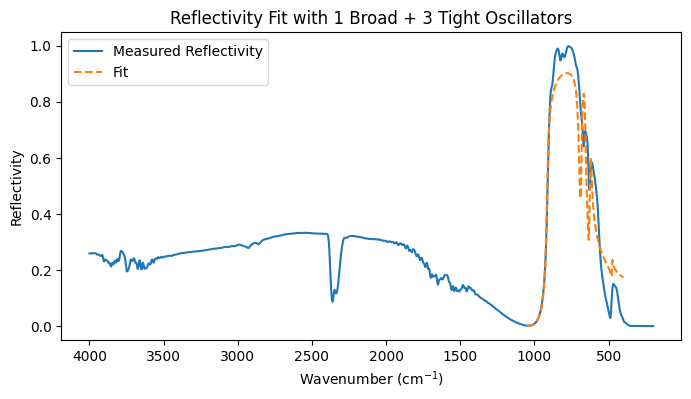

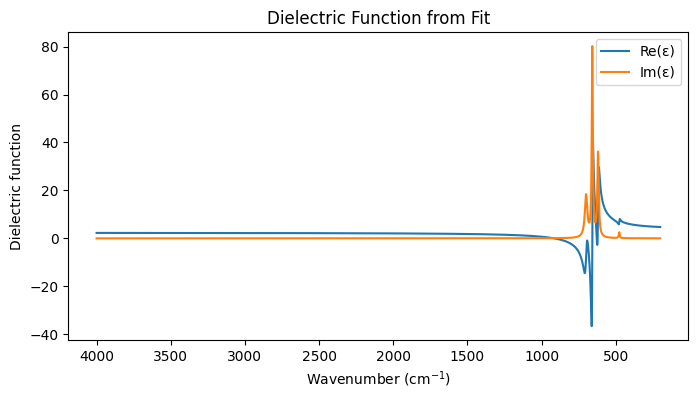

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def dielectric_function(w, eps_inf,
                        S1, w01, g1,
                        S2, w02, g2,
                        S3, w03, g3,
                        S4, w04, g4):
    i = 1j
    eps = eps_inf + \
          S1 * w01**2 / (w01**2 - w**2 - i * g1 * w) + \
          S2 * w02**2 / (w02**2 - w**2 - i * g2 * w) + \
          S3 * w03**2 / (w03**2 - w**2 - i * g3 * w) + \
          S4 * w04**2 / (w04**2 - w**2 - i * g4 * w)
    return eps

def reflectivity_model(w, eps_inf,
                      S1, w01, g1,
                      S2, w02, g2,
                      S3, w03, g3,
                      S4, w04, g4):
    eps = dielectric_function(w, eps_inf,
                              S1, w01, g1,
                              S2, w02, g2,
                              S3, w03, g3,
                              S4, w04, g4)
    sqrt_eps = np.sqrt(eps)
    R = np.abs((1 - sqrt_eps) / (1 + sqrt_eps))**2
    return R.real

# Initial guesses:
p0 = [
    1.0,       # eps_inf
    1.5, 850.0, 50.0,   # Broad oscillator (main peak) -- big gamma for broadness
    0.3, 650.0, 8.0,     # Bump near 650
    0.3, 620.0, 8.0,     # Bump near 620
    0.15, 475.0, 8.0     # Minor peak near 475
]

# Bounds:
lower_bounds = [
    0.01,        # eps_inf
    0.5, 700, 20.0,      # Broad oscillator: centered near peak with broad gamma
    0.005, 630, 3.0,      # Bump near 650
    0.005, 600, 1.0,      # Bump near 620
    0.001, 460, 3.0       # Minor peak near 475
]

upper_bounds = [
    5.0,
    3.0, 1000, 200.0,      # Broad oscillator gamma max extended for broadness
    1.0, 750, 50.0,
    1.0, 640, 20.0,
    0.5, 490, 20.0
]

# Use your wavenumber and reflectivity arrays here:
wavenumber = np.array(spectrum_dict['Sapphire Reflectivity']['Wavenumber'])
R_normalized = np.array(smoothed_Y)

# Optional fitting range to focus:
fit_mask = (wavenumber > 400) & (wavenumber < 1050)
w_fit = wavenumber[fit_mask]
R_fit = R_normalized[fit_mask]

# Fit
popt, pcov = curve_fit(reflectivity_model, w_fit, R_fit, p0=p0, bounds=(lower_bounds, upper_bounds), maxfev=5000)

print("Fitted parameters:")
param_names = ['eps_inf',
               'S1', 'w01', 'g1',
               'S2', 'w02', 'g2',
               'S3', 'w03', 'g3',
               'S4', 'w04', 'g4']

for name, val in zip(param_names, popt):
    print(f"{name} = {val:.4f}")

# Plot results
plt.figure(figsize=(8,4))
plt.plot(wavenumber, R_normalized, label='Measured Reflectivity')
plt.plot(w_fit, reflectivity_model(w_fit, *popt), '--', label='Fit')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Reflectivity')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Reflectivity Fit with 1 Broad + 3 Tight Oscillators')
plt.show()

# Plot dielectric function components
eps_fit = dielectric_function(wavenumber, *popt)
plt.figure(figsize=(8,4))
plt.plot(wavenumber, eps_fit.real, label='Re(ε)')
plt.plot(wavenumber, eps_fit.imag, label='Im(ε)')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Dielectric function')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Dielectric Function from Fit')
plt.show()


Fitted parameters:
eps_inf = 1.594
S1 = 1.522
w01 = 650.000
g1 = 10.889


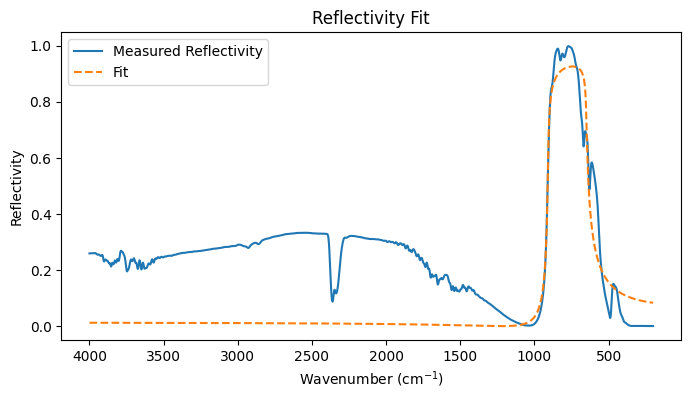

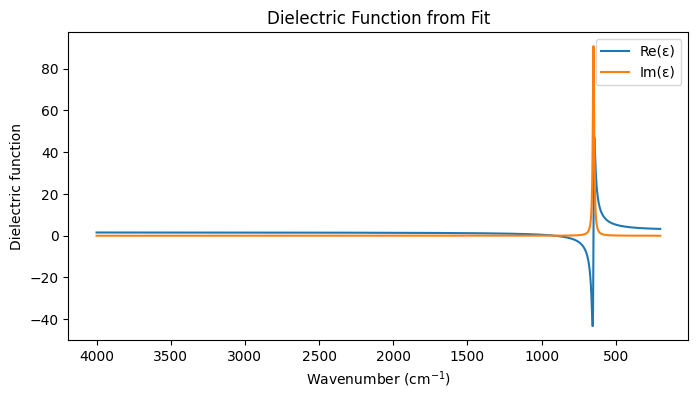

In [90]:
# # Oscillator 1 fitted values (from your last fit)
# S1_fit = 1.77
# w01_fit = 647.0
# g1_fit = 11.5

# # Bounds with small wiggle room
# S1_bounds = (S1_fit - 0.3, S1_fit + 0.3)
# w01_bounds = (w01_fit - 10, w01_fit + 10)
# g1_bounds = (g1_fit - 3, g1_fit + 3)

# Define dielectric function separately (Lorentz oscillators)
def dielectric_function(w, eps_inf,
                        S1, w01, g1,
                        #S2, w02, g2,
                        #S3, w03, g3
        # S4, w04, g4
):
    i = 1j
    eps = eps_inf + \
          S1 * w01**2 / (w01**2 - w**2 - i * g1 * w) #+ \
          #S2 * w02**2 / (w02**2 - w**2 - i * g2 * w) + \
          #S3 * w03**2 / (w03**2 - w**2 - i * g3 * w)
    return eps

# Reflectivity model to fit (returns R)
def reflectivity_model(w, eps_inf,
                        S1, w01, g1,
                        #S2, w02, g2,
                        #S3, w03, g3
):
    eps = dielectric_function(w, eps_inf,
                            S1, w01, g1,
                            #S2, w02, g2,
                            #S3, w03, g3
    )
    sqrt_eps = np.sqrt(eps)
    R = np.abs((1 - sqrt_eps) / (1 + sqrt_eps))**2
    return R.real  # real, since reflectivity is real-valued

# Initial parameter guesses
p0 = [
    1.809,        # eps_inf
    1, 650, 10,  # S1, w01, g1
    #4.0, 900.0, 20.0,  # S2, w02, g2
    #0.5, 700.0, 10.0   # S3, w03, g3
]

param_names = [
    'eps_inf',
    'S1', 'w01', 'g1',
    'S2', 'w02', 'g2',
    'S3', 'w03', 'g3'
]
lower_bounds = [
    0.5,     # eps_inf
    0.5, 650, 10  # S1, w01, g1
    #0.0, 850.0, 1.0,  # S2, w02, g2
    #0.0, 680.0, 1.0   # S3, w03, g3
]
upper_bounds = [
    10.0,
    4, 750, 20
    #20.0, 950.0, 50.0,
    #20.0, 720.0, 20.0
]

wavenumber = np.array(spectrum_dict['Sapphire Reflectivity']['Wavenumber'])
R_normalized = np.array(smoothed_Y)

# Optional: restrict fitting range to where phonon modes appear, e.g. 400-1300 cm^-1
fit_mask = (wavenumber > 300) & (wavenumber < 1000)
w_fit = wavenumber[fit_mask]
R_fit = R_normalized[fit_mask]

popt, pcov = curve_fit(
    reflectivity_model,
    w_fit,
    R_fit,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
    maxfev=5000
)

print("Fitted parameters:")
for name, val in zip(param_names, popt):
    print(f"{name} = {val:.3f}")

# Calculate dielectric function using fitted params
eps_fit = dielectric_function(wavenumber, *popt)

# Plot reflectivity fit
plt.figure(figsize=(8,4))
plt.plot(wavenumber, R_normalized, label='Measured Reflectivity')
plt.plot(wavenumber, reflectivity_model(wavenumber, *popt), '--', label='Fit')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Reflectivity')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Reflectivity Fit')
plt.show()

# Plot dielectric function
plt.figure(figsize=(8,4))
plt.plot(wavenumber, eps_fit.real, label='Re(ε)')
plt.plot(wavenumber, eps_fit.imag, label='Im(ε)')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Dielectric function')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Dielectric Function from Fit')
plt.show()


Fitted oscillator 2 parameters:
S2 = 1.000
w02 = 880.000
g2 = 15.000


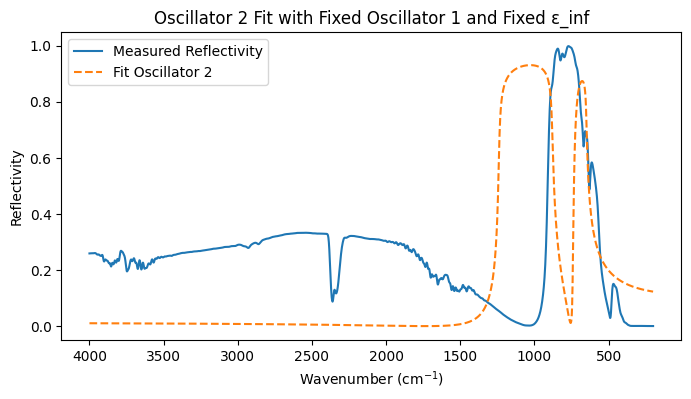

In [95]:
# Fixed first oscillator parameters (from your step 1 fit)
S1_fixed = popt[1]
w01_fixed = popt[2]
g1_fixed = popt[3]
eps_inf_fixed = popt[0]  # fix epsilon_inf to previous fit

def dielectric_function_osc2_fixed_eps(w, S2, w02, g2):
    i = 1j
    eps = eps_inf_fixed + \
          S1_fixed * w01_fixed**2 / (w01_fixed**2 - w**2 - i * g1_fixed * w) + \
          S2 * w02**2 / (w02**2 - w**2 - i * g2 * w)
    return eps

def reflectivity_model_osc2_fixed_eps(w, S2, w02, g2):
    eps = dielectric_function_osc2_fixed_eps(w, S2, w02, g2)
    sqrt_eps = np.sqrt(eps)
    R = np.abs((1 - sqrt_eps) / (1 + sqrt_eps))**2
    return R.real

# Use a narrow fit range around the second peak only (e.g., 850-1000)
fit_mask_osc2 = (wavenumber > 850) & (wavenumber < 1000)
w_fit_osc2 = wavenumber[fit_mask_osc2]
R_fit_osc2 = R_normalized[fit_mask_osc2]

p0_osc2 = [
    4.0,      # S2 initial guess
    900.0,    # w02 initial guess
    10.0      # g2 initial guess
]

lower_bounds_osc2 = [
    1.0,      # S2 lower bound
    880.0,    # w02 lower bound
    1.0       # g2 lower bound
]

upper_bounds_osc2 = [
    6.0,      # S2 upper bound
    940.0,    # w02 upper bound
    15.0      # g2 upper bound
]

popt_osc2, pcov_osc2 = curve_fit(
    reflectivity_model_osc2_fixed_eps,
    w_fit_osc2,
    R_fit_osc2,
    p0=p0_osc2,
    bounds=(lower_bounds_osc2, upper_bounds_osc2),
    maxfev=5000
)

print("Fitted oscillator 2 parameters:")
param_names_osc2 = ['S2', 'w02', 'g2']
for name, val in zip(param_names_osc2, popt_osc2):
    print(f"{name} = {val:.3f}")

# Plot result for oscillator 2 fitting
eps_fit_osc2 = dielectric_function_osc2_fixed_eps(wavenumber, *popt_osc2)

plt.figure(figsize=(8,4))
plt.plot(wavenumber, R_normalized, label='Measured Reflectivity')
plt.plot(wavenumber, reflectivity_model_osc2_fixed_eps(wavenumber, *popt_osc2), '--', label='Fit Oscillator 2')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Reflectivity')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Oscillator 2 Fit with Fixed Oscillator 1 and Fixed ε_inf')
plt.show()
